# CIVL 509 Final Project
Shelby Quiring, 10157162, March 22nd 2024

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt 
import scipy as sci
import sympy as sp

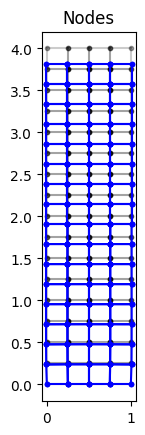

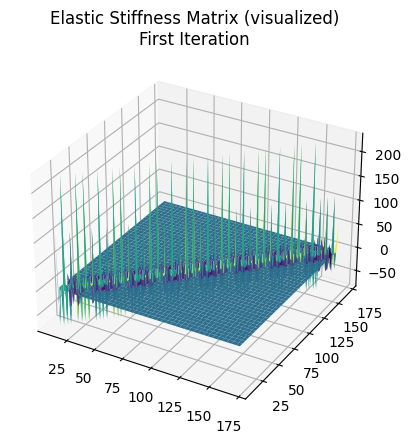

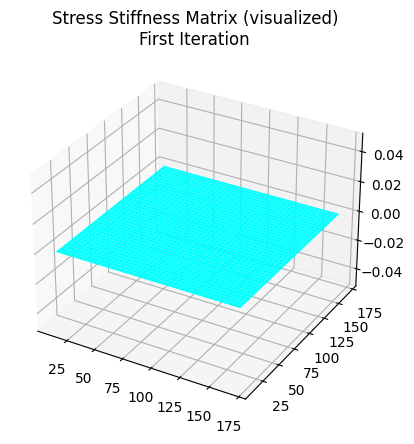

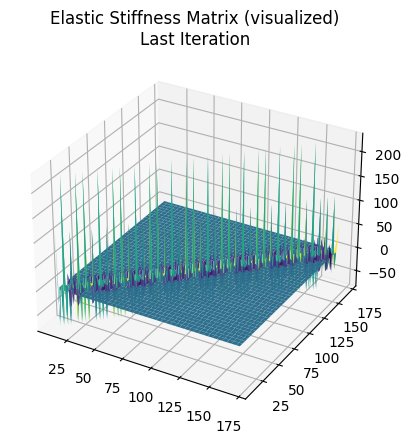

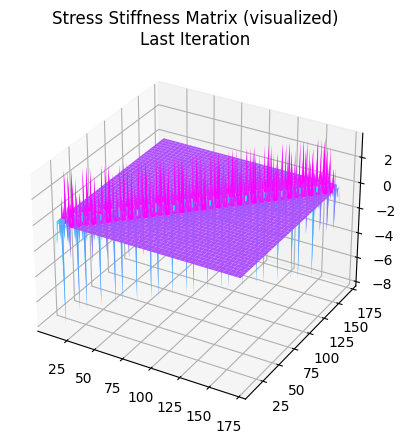

In [2]:
# Implement a simple solver based on MECH 462

# Material properties
E = 100  # Young modulus in [N/m^2]
v = 0.3  # Poisson

# Size of the structure
Lx = 1  # Length in x direction, m
Ly = 4

# Mesh
dims = 2
el_per_m = 4 # Mesh density
nx = Lx*el_per_m  # n. elements in x
ny = Ly*el_per_m 

m = nx*ny # total n. of elements

Dx = Lx/nx  # size of the element along x
Dy = Ly/ny  # Size of elements along y

# Nodes
N = (nx+1) * (ny+1) # total n. of nodes

# Node grid - we use here a grid numeration
ix = np.arange(0, nx+1)
iy = np.arange(0, ny+1)

# Node position
x = (ix)*Dx
y = (iy)*Dy
xn, yn = np.meshgrid(x,y)

# Define reordering matrix (FROM stack-by-letter TO stack-by-node)
R = np.zeros((8, 8))
R[np.arange(0, 8, 2), np.arange(0, 4, 1)] = 1  # x positions
R[np.arange(1, 8, 2), np.arange(4, 8, 1)] = 1  # y positions

# Stress strain matrix
Em = np.array([
    [ (1-v),   v,       0     ],
    [   v,   (1-v),     0     ],
    [   0,     0,   (1-2*v)/2 ]
]) * E/((1+v)*(1-2*v))  # plane strain

Sm = np.zeros((2, 2))

# T Matrix
T = np.array([
    [ 1, 0, 0, 0 ],
    [ 0, 0, 0, 1 ],
    [ 0, 1, 1, 0 ]
])

# Gauss points
gauss = np.array([
    [ -1, -1 ],
    [  1, -1 ],
    [ -1,  1 ],
    [  1,  1 ]
]) / np.sqrt(3)

# Initialize displacements
u = np.zeros(2*N) 

# Boundary conditions
ixfix = np.arange(0, nx + 1)  # position of the fixed nodes in the node grid
iyfix = 0
ifix = iyfix * (nx + 1) + ixfix
fix_dofs = np.concatenate([2*(ifix)+1, 2*(ifix)]) # both u and v are constrained here

# Loads
f = np.zeros((2*N, 1))
q = -5 # this is the distributed load at the top surface in [N/m]
ixload = np.arange(0, nx+1)  # position of the loaded nodes in the node grid
iyload = ny 
iload = iyload * (nx+1) + ixload
load_dofs = 2*(iload)+1  # we are loading in the y direction
xload = np.array([
   [xn[iyload, 0], *xn[iyload], xn[iyload, -1]]
   ])
f[load_dofs] = q * 0.5 * np.array([xload[0][2:] - xload[0][:-2]]).T

# Define the output plotting function
def plot_output(u):
  fig, ax = plt.subplots()
  mdx = -1
  for jdx in range(ny):
    for idx in range(nx):
      mdx += 1
      
      x1 = xn[jdx, idx]
      x2 = xn[jdx, idx+1]
      x3 = x1
      x4 = x2

      y1 = yn[jdx, idx] 
      y2 = y1 
      y3 = yn[jdx+1, idx]
      y4 = y3

      i_loc = jdx * (nx + 1) + idx
      j_loc = i_loc + (nx + 1)

      i = jdx*(nx+1)+idx 
      j = i+nx+1

      p1 = 2*i
      p2 = 2*i+1
      p3 = 2*(i+1)
      p4 = 2*(i+1)+1
      p5 = 2*j
      p6 = 2*j+1
      p7 = 2*(j+1)
      p8 = 2*(j+1)+1
      locations = [p1, p2, p3, p4, p5, p6, p7, p8]
      
      u1 = u[p1]
      v1 = u[p2]

      u2 = u[p3] 
      v2 = u[p4]

      u3 = u[p5] 
      v3 = u[p6]

      u4 = u[p7] 
      v4 = u[p8]


      a=0.2
      ax.plot([x1,x2],[y1,y2],'k.-', alpha = a)
      ax.plot([x1,x3],[y1,y3],'k.-', alpha = a)
      ax.plot([x2,x4],[y2,y4],'k.-', alpha = a)
      ax.plot([x3,x4],[y3,y4],'k.-', alpha = a)
      ax.plot([x1+u1,x2+u2],[y1+v1,y2+v2],'b.-')
      ax.plot([x1+u1,x3+u3],[y1+v1,y3+v3],'b.-')
      ax.plot([x2+u2,x4+u4],[y2+v2,y4+v4],'b.-')
      ax.plot([x3+u3,x4+u4],[y3+v3,y4+v4],'b.-')
          
  ax.set_title('Nodes')
  ax.set_aspect('equal')

# Calculations
iterations = 15
for z in range(iterations):
  # Stiffness matrix
  K = np.zeros((2*N, 2*N))
  S = np.zeros((2*N, 2*N))
  B = np.zeros((3*m, 2*N))

  # Construct the stiffness matrix
  mdx = -1
  for idx in range(nx):
    for jdx in range(ny):
        i_loc = jdx * (nx + 1) + idx
        j_loc = i_loc + (nx + 1)
        mdx += 1

        # Define local dofs
        local_dofs = [2*i_loc, 2*i_loc+1, 2*(i_loc+1), 2*(i_loc+1)+1, 2*j_loc, 2*j_loc+1, 2*(j_loc+1), 2*(j_loc+1)+1]
        
        # Extract the positions of the 4 corners
        x1 = xn[jdx, idx] 
        x2 = xn[jdx, idx+1] 
        x3 = x1 
        x4 = x2

        y1 = yn[jdx, idx] 
        y2 = y1 
        y3 = yn[jdx+1, idx] 
        y4 = y3

        Kq = np.zeros((8, 8)) # Initialize the local stiffness matrix
        Sq = np.zeros((4, 4)) # Initialize the local STRESS stiffness matrix
        uq = u[local_dofs]

        for xx, yy in gauss:  # for each Gauss point

            # Define the local shape function derivatives
            Nxx = np.array([-0.25*(1-yy), 0.25*(1-yy), -0.25*(1+yy), 0.25*(1+yy)])
            Nyy = np.array([-0.25*(1-xx), -0.25*(1+xx), 0.25*(1-xx), 0.25*(1+xx)])

            # Make a matrix for stress stiffness calculations
            dN = np.block([
              [Nxx],
              [Nyy]
            ])

            # Define the jacobian
            J = np.block([
              [Nxx @ np.array([x1, x2, x3, x4]), Nxx @ np.array([y1, y2, y3, y4])],
              [Nyy @ np.array([x1, x2, x3, x4]), Nyy @ np.array([y1, y2, y3, y4])] 
              ])
            
            # Calculate the determinant of the jacobian and its inverse
            dJ = np.linalg.det(J)
            iJ = np.linalg.inv(J)

            C = np.block([
              [iJ, np.zeros((2,2))],
              [np.zeros((2,2)), iJ]
              ])
            
            A = T @ C
            
            G = np.array([
                [ Nxx[0],   0,    Nxx[1],   0,    Nxx[2],   0,    Nxx[3],   0 ],
                [ Nyy[0],   0,    Nyy[1],   0,    Nyy[2],   0,    Nyy[3],   0 ],
                [ 0,    Nxx[0],  0,    Nxx[1],   0,    Nxx[2],   0,    Nxx[3] ],
                [ 0,    Nyy[0],  0,    Nyy[1],   0,    Nyy[2],   0,    Nyy[3] ]
                ])

            Bq = A @ G    # For elastic stiffness matrix
            dNj = iJ @ dN # Original
            
            # Calculate the local stress matrix in this element
            em = Bq @ uq  # Strain vector
            Sm_vec = Em @ em  # Stress vector
            Sm = np.block([   # Cauchy matrix
               [   Sm_vec[0], 2*Sm_vec[2] ],
               [ 2*Sm_vec[2],   Sm_vec[1] ]
            ])

            Kq = Kq + Bq.T @ Em @ Bq * dJ
            Sq = Sq + dNj.T @ Sm @ dNj * dJ

        # Define the local degrees of freedom and update the stiffness matrix
        K[np.ix_(local_dofs, local_dofs)] += Kq

        # Calculate full stress stiffness matrix and add it 
        S_1 = np.block([
          [Sq, np.zeros_like(Sq)],
          [np.zeros_like(Sq), Sq]
        ])
        S_2 = R @ S_1 @ R.T  # Reorder the dofs to stack-by-node instead of stack-by-direction
        S[np.ix_(local_dofs, local_dofs)] += S_2  
        
        # Add to the total B matrix
        B[np.ix_(np.arange(0, 3) + mdx*3, local_dofs)] += Bq


  # Solution
  free_dofs = np.setdiff1d(np.arange(0, 2*N), fix_dofs)
  K_free = K[np.ix_(free_dofs, free_dofs)]
  S_free = S[np.ix_(free_dofs, free_dofs)]
  K_total_free = K_free + S_free
  u[free_dofs] = np.linalg.solve(K_total_free, f[free_dofs]).T[0]

  if z == 0: # Plot the first iteration
    plot_output(u)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    xx, yy = np.meshgrid(free_dofs, free_dofs)
    ax.plot_surface(xx, yy, K_free, cmap='viridis')
    ax.set_title('Elastic Stiffness Matrix (visualized)\nFirst Iteration')

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    xx, yy = np.meshgrid(free_dofs, free_dofs)
    ax.plot_surface(xx, yy, S_free, cmap='cool')
    ax.set_title('Stress Stiffness Matrix (visualized)\nFirst Iteration')

  if z == (iterations-1): # Plot the final iteration
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    xx, yy = np.meshgrid(free_dofs, free_dofs)
    ax.plot_surface(xx, yy, K_free, cmap='viridis')
    ax.set_title('Elastic Stiffness Matrix (visualized)\nLast Iteration')

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    xx, yy = np.meshgrid(free_dofs, free_dofs)
    ax.plot_surface(xx, yy, S_free, cmap='cool')
    ax.set_title('Stress Stiffness Matrix (visualized)\nLast Iteration')

Eigval: 0.2670725589152213
Eigval: 1.7491410729778558
Eigval: 3.251669640964168


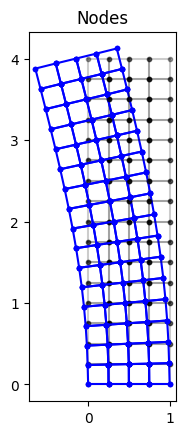

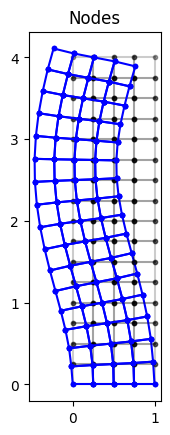

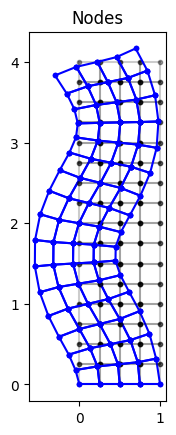

In [3]:
# The eigenvalues resulting from this formulation are the inverse load factors
# https://web.mit.edu/kjb/www/Publications_Prior_to_1998/Solution_Methods_for_Eigenvalue_Problems_in_Structural_Mechanics.pdf
e, V = sci.linalg.eig(sci.linalg.inv(K_free) @ S_free)

# Sort eigenvalues to get the lowest ones first
sorted_values = sorted(zip(e, np.arange(np.shape(e)[0])), key = lambda x: np.abs(x[0]), reverse=True)
indices = np.array(sorted_values).T[1]
min_eigval = 0 # initialize a variable to store the lowest eigenvalue

# Plot the first 3 buckling modes and report the eigenvalues
for idx in indices[:3]:
    idx = int(np.real(idx))

    # Extract the eigenvalue
    eigval = -np.real(1/e[idx])
    print(f'Eigval: {eigval}')

    if idx == 0: # Record the minimum eigenvalue
        min_eigval = eigval

    # Extract the eigenvector
    eigvec = V.T[idx]
    eigvec_aug = np.zeros_like(u)
    eigvec_aug[free_dofs] = np.real(eigvec) # Add 0's to all the constrained nodes
    
    # Plot the response, exaggerated by 3x
    plot_output(eigvec_aug * 3)

In [4]:
# Calculate analytical buckling load
b = 1    # Depth into page
h = Lx   # Beam height
L = Ly   # Beam length
I = b * h**3 / 12 # Inertia
Leff = 2*L  # Effective length
Pcr_analytical = -np.pi**2 * E * I /  Leff**2  # Analytical buckling load

# Predicted budkling load from finite element analysis
Pcr_FEA = q * (b * h) * np.real(min_eigval)

# Report values
print(f'Pcr Analytical: {Pcr_analytical:.2f}')
print(f'Pcr FEA: {Pcr_FEA:.2f}')

Pcr Analytical: -1.29
Pcr FEA: -1.34
